# Travel time prediction in Bangalore using Uber's movement data

In [1]:
#https://www.kaggle.com/nithintom/uber-travel-time-prediction
import pandas as pd
import geopandas as gpd
import requests
import shapely
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
travel_times = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times.csv')
travel_times_daily = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_Daily.csv')
travel_times_day = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_time_of_day.csv')
travel_times_week = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_day_of_week.csv')
bnglr_wards_hourly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-All-HourlyAggregate.csv')
bnglr_wards_weekly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-WeeklyAggregate.csv')
bnglr_wards_monthly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-All-MonthlyAggregate.csv')

In [3]:
travel_times.head(2)
travel_times.columns

Index(['Origin Movement ID', 'Origin Display Name', 'Destination Movement ID',
       'Destination Display Name', 'Date Range', 'Mean Travel Time (Seconds)',
       'Range - Lower Bound Travel Time (Seconds)',
       'Range - Upper Bound Travel Time (Seconds)'],
      dtype='object')

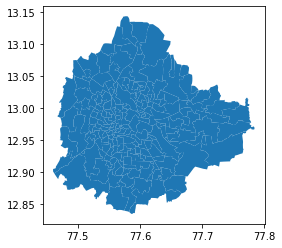

In [4]:
bglr=gpd.read_file('/kaggle/input/uber-movement-data/bangalore_wards.json')
bglr.plot()

In [5]:
print(bglr.geometry)

0      MULTIPOLYGON (((77.59229 13.09720, 77.59094 13...
1      MULTIPOLYGON (((77.56862 13.12705, 77.57064 13...
2      MULTIPOLYGON (((77.59094 13.09842, 77.59229 13...
3      MULTIPOLYGON (((77.67683 13.01147, 77.67695 13...
4      MULTIPOLYGON (((77.72899 13.02061, 77.72994 13...
                             ...                        
193    MULTIPOLYGON (((77.61399 12.92347, 77.61419 12...
194    MULTIPOLYGON (((77.68336 13.05192, 77.68384 13...
195    MULTIPOLYGON (((77.64931 13.07853, 77.64993 13...
196    MULTIPOLYGON (((77.68549 12.94121, 77.68539 12...
197    MULTIPOLYGON (((77.49854 12.92574, 77.49854 12...
Name: geometry, Length: 198, dtype: geometry


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


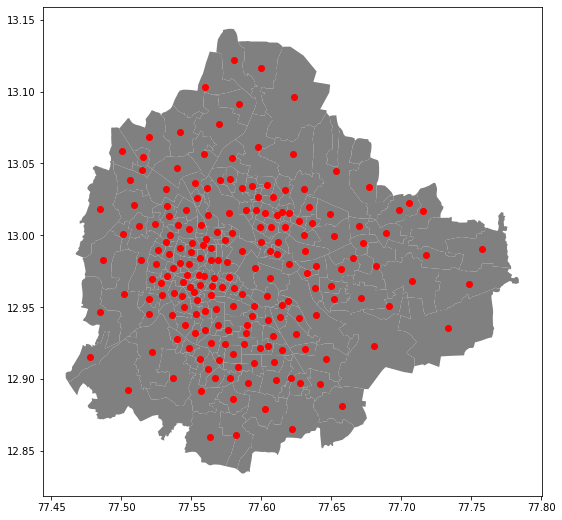

In [6]:
bglr_c = bglr.copy()
bglr_c.geometry= bglr_c['geometry'].centroid
fig, ax = plt.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
bglr_c.plot(color='red',ax=ax)

In [7]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()


,id,name
0,1,"Unnamed Road, Bengaluru"
1,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya..."
2,3,"15th A Cross Road, Yelahanka Satellite Town, Y..."
3,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay..."
4,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish..."


In [8]:
time_df = pd.merge(bnglr_wards_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
272319,198,197,20,4001.08,583.40,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272337,198,197,21,3636.68,614.63,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272324,198,197,22,3082.11,471.47,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272330,198,197,23,2905.84,619.53,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
366043,198,198,23,458.84,562.24,"BGS Road, Kodipalya, Bengaluru","BGS Road, Kodipalya, Bengaluru"


In [9]:
bglr_c.geometry

0      POINT (77.58042 13.12171)
1      POINT (77.56004 13.10280)
2      POINT (77.58393 13.09099)
3      POINT (77.66957 13.00606)
4      POINT (77.71546 13.01685)
                 ...            
193    POINT (77.61442 12.92002)
194    POINT (77.67654 13.03361)
195    POINT (77.65327 13.04456)
196    POINT (77.69150 12.95074)
197    POINT (77.50501 12.89190)
Name: geometry, Length: 198, dtype: geometry

In [10]:
bglr_c.DISPLAY_NAME

0                                Unnamed Road, Bengaluru
1      9th Cross Bhel Layout, Adityanagar, Vidyaranya...
2      15th A Cross Road, Yelahanka Satellite Town, Y...
3      SP Naidu Layout 4th Cross Street, SP Naidu Lay...
4      Medahalli Kadugodi Road, Bharathi Nagar, Krish...
                             ...                        
193    0 1st B Cross Road, Cashier Layout, 1st Stage,...
194    Kalkere-Agara Main Road, Horamavu Agara, Kalke...
195    0 Horamavu Agara Main Road, 1st Block, Mallapp...
196    0 3rd Cross Road, Manjunatha Layout, Marathaha...
197                       BGS Road, Kodipalya, Bengaluru
Name: DISPLAY_NAME, Length: 198, dtype: object

In [11]:
time_df2 = pd.merge(time_df, bglr_c, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['WARD_NO', 'MOVEMENT_ID', 'DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, bglr_c, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['WARD_NO', 'MOVEMENT_ID', 'DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.tail()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Ward Name,Source Geometry,Destination Ward Name,Destination Geometry
826687,198,119,15,2231.38,406.41,"BGS Road, Kodipalya, Bengaluru","0 5th Main Road, Kempapura Agrahara, Bengaluru",Hemmigepura,POINT (77.50501 12.89190),Kempapura Agrahara,POINT (77.55548 12.97231)
826688,198,119,16,2292.29,453.34,"BGS Road, Kodipalya, Bengaluru","0 5th Main Road, Kempapura Agrahara, Bengaluru",Hemmigepura,POINT (77.50501 12.89190),Kempapura Agrahara,POINT (77.55548 12.97231)
826689,198,119,19,2476.56,365.31,"BGS Road, Kodipalya, Bengaluru","0 5th Main Road, Kempapura Agrahara, Bengaluru",Hemmigepura,POINT (77.50501 12.89190),Kempapura Agrahara,POINT (77.55548 12.97231)
826690,198,119,20,1914.13,230.32,"BGS Road, Kodipalya, Bengaluru","0 5th Main Road, Kempapura Agrahara, Bengaluru",Hemmigepura,POINT (77.50501 12.89190),Kempapura Agrahara,POINT (77.55548 12.97231)
826691,198,119,21,2146.00,426.03,"BGS Road, Kodipalya, Bengaluru","0 5th Main Road, Kempapura Agrahara, Bengaluru",Hemmigepura,POINT (77.50501 12.89190),Kempapura Agrahara,POINT (77.55548 12.97231)


In [21]:
final_df = time_df2.copy()
final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))
final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))

features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', ]
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]
final_df.head()

,Source lat,Source long,Dest lat,Dest long,hod,mean_travel_time
0,77.580422,13.121709,77.580422,13.121709,23,443.13
1,77.560038,13.102805,77.580422,13.121709,0,227.61
2,77.560038,13.102805,77.580422,13.121709,1,240.99
3,77.560038,13.102805,77.580422,13.121709,2,304.60
4,77.560038,13.102805,77.580422,13.121709,3,381.67


In [25]:
import xgboost as xgb
import pickle

my_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, n_jobs=4)
my_model.fit(final_df[features], final_df[outcome],
             verbose=False)

pickle.dump(my_model, open('XGB_movement_data.bin', 'wb'))

In [41]:
x=pd.DataFrame(columns=features, data=[[77.560038 ,13.102805 ,77.580422 ,13.121709 ,1 ]])
my_model.predict(x)

array([349.4991], dtype=float32)